In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import shap
import pickle

In [2]:
pd.options.display.float_format = '{:.2f}'.format

In [3]:
df = pd.read_parquet('data/historical_data.parquet')
df

,txn_id,time_stamp,txn_maker_address,txn_receiver_address,txn_value,method_called,token_price,liquidity,market_cap,hour,weekday_number,weekday_name,txn_time_gap,txn_value_to_token_price,txn_value_to_liquidity,txn_value_to_market_cap
0,85214fe243b6d9be9765c12ed0ed32644464437e218eaf...,2024-07-29 00:00:00,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.19,swap,2.30,1153266.06,3235211.29,0,0,Monday,nan,95.33,0.00,0.00
1,962bf70bec6ea9bdf5f046d20a7c832f193ad698346cce...,2024-07-29 00:02:52,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,2.71,buy,2.31,1153247.33,3235412.69,0,0,Monday,172.00,117.24,0.00,0.00
2,58910261cc6a646dbe640094d8813bd77e6b68eb56b569...,2024-07-29 00:05:11,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,3.54,swap,2.29,1153285.00,3235707.52,0,0,Monday,139.00,154.22,0.00,0.00
3,e7ac9a71df5e5db5a37eec0ccdb79bea177552173c6c44...,2024-07-29 00:08:03,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,3.91,printMoney,2.30,1153290.16,3236090.14,0,0,Monday,172.00,169.78,0.00,0.00
4,ce31abfd8bdd378cc1b41b8dfb2b7c326e5d47f7280a15...,2024-07-29 00:09:13,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,3.27,transfer,2.28,1153268.86,3235590.53,0,0,Monday,70.00,143.78,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639,1eeeed73fb6c67dabc70360ac73f0d7705853d166d841b...,2024-08-01 23:44:26,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.70,buy,2.30,1153299.71,3235789.09,23,3,Thursday,518.00,117.28,0.00,0.00
8640,ecfd8a3341771976c4d74e3d1284389966f125f5217b68...,2024-08-01 23:52:30,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,2.49,transfer,2.28,1153273.46,3235821.57,23,3,Thursday,484.00,108.85,0.00,0.00
8641,a5f180b4e56b70851cc85aa80e623b7820654480711d10...,2024-08-01 23:58:16,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.90,transfer,2.30,1153254.65,3234902.08,23,3,Thursday,346.00,126.27,0.00,0.00
8642,34fa716a537c8ede36b56b0ffc02932da8f50d9dc01e24...,2024-08-01 23:59:25,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x00000000fc65059bDdA566b43E17c310B3076e33,2.92,transfer,2.32,1153282.39,3235571.15,23,3,Thursday,69.00,125.86,0.00,0.00


In [4]:
replace_dict = {'buy': 1, 'transfer': 2, 'swap': 3, 'printMoney': 4}
df['method'] = df['method_called'].replace(replace_dict)

# LARGE TRANSACTION MODEL

In [5]:
input_feature = ['txn_value', 'method', 'token_price', 'liquidity', 'market_cap', 'hour', 'weekday_number',
                 'txn_value_to_token_price', 'txn_value_to_liquidity', 'txn_value_to_market_cap']

In [6]:
model = IsolationForest(n_estimators=300,
                      contamination=0.01,
                      max_features=len(input_feature),
                      verbose=0,
                      random_state=0)

In [7]:
model.fit(df[input_feature])

IsolationForest(contamination=0.01, max_features=10, n_estimators=300,
                random_state=0)

In [8]:
df['large_transaction'] = model.predict(df[input_feature])
df['large_transaction_score'] = model.decision_function(df[input_feature])

In [9]:
df[df.method_called == 'buy']

,txn_id,time_stamp,txn_maker_address,txn_receiver_address,txn_value,method_called,token_price,liquidity,market_cap,hour,weekday_number,weekday_name,txn_time_gap,txn_value_to_token_price,txn_value_to_liquidity,txn_value_to_market_cap,method,large_transaction,large_transaction_score
1,962bf70bec6ea9bdf5f046d20a7c832f193ad698346cce...,2024-07-29 00:02:52,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,2.71,buy,2.31,1153247.33,3235412.69,0,0,Monday,172.00,117.24,0.00,0.00,1,1,0.10
7,ae276e3060960e3db289d1b5dce934773c7a6d9359fc9e...,2024-07-29 00:27:04,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,2.32,buy,2.31,1153275.55,3235525.86,0,0,Monday,449.00,100.36,0.00,0.00,1,1,0.12
14,0aa05aa77515d1aeee3007393d82f093eee204a7c8d0ba...,2024-07-29 01:18:55,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,2.52,buy,2.29,1153291.04,3235284.61,1,0,Monday,139.00,109.79,0.00,0.00,1,1,0.13
39,d0554b6d289a012397ad5549303e7f7f0f07c5e62c9cf5...,2024-07-29 03:08:22,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,3.96,buy,2.31,1153287.06,3234976.47,3,0,Monday,35.00,171.44,0.00,0.00,1,1,0.09
43,a6bf190a1741272222802c5839e194240b33a7ec9dc6fa...,2024-07-29 03:28:31,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,2.51,buy,2.35,1153313.59,3235630.26,3,0,Monday,345.00,106.76,0.00,0.00,1,1,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8629,ecd5250e9c578a3818f27b92d35f8899ae0c71872692d5...,2024-08-01 22:45:41,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x4E3288c9ca110bCC82bf38F09A7b425c095d92Bf,2.48,buy,2.29,1153285.28,3236021.94,22,3,Thursday,104.00,108.26,0.00,0.00,1,1,0.12
8631,a825807a7657cc12e4a23e284e145f06fbaa217e97e449...,2024-08-01 22:57:47,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x00000000fc65059bDdA566b43E17c310B3076e33,3.50,buy,2.32,1153311.94,3235788.30,22,3,Thursday,381.00,150.48,0.00,0.00,1,1,0.12
8632,93fb411d98b47b8e805550bd00b83a4a7d2a7e6fa372bb...,2024-08-01 23:08:43,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,3.53,buy,2.32,1153268.49,3235913.47,23,3,Thursday,656.00,152.16,0.00,0.00,1,1,0.12
8636,65eeb094107a8baec0abeda2400ad00b7c1eb3a50c579a...,2024-08-01 23:26:35,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x00000000041d945c46E073F0048cEf510D148dEA,2.32,buy,2.33,1153284.89,3235423.90,23,3,Thursday,622.00,99.71,0.00,0.00,1,1,0.12


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


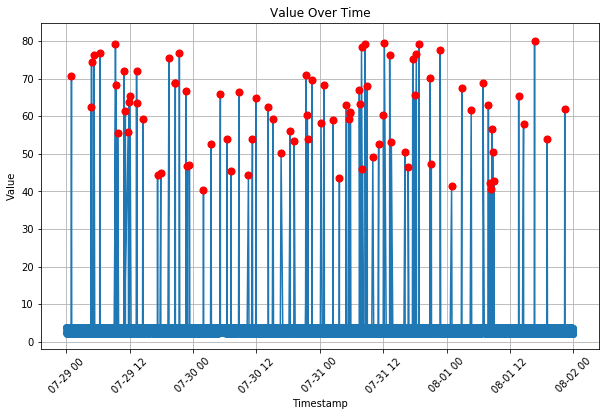

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(df['time_stamp'], df['txn_value'], marker='o', linestyle='-')
plt.title('Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.scatter(df[df['large_transaction'] == -1]['time_stamp'], df[df['large_transaction'] == -1]['txn_value'], 
            color='red', s=50, label='anomalies', zorder=5)  # Larger size for highlighted points
plt.show()

In [11]:
X = pd.concat([df[df.large_transaction==1][input_feature].head(50), df[df.large_transaction==-1][input_feature].head(50)], ignore_index=True)

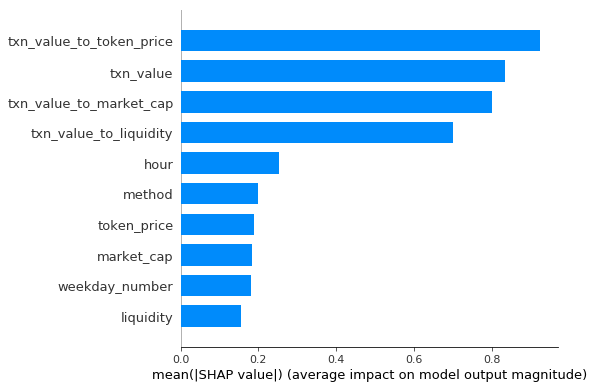

In [12]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

  0%|          | 0/100 [00:00<?, ?it/s]

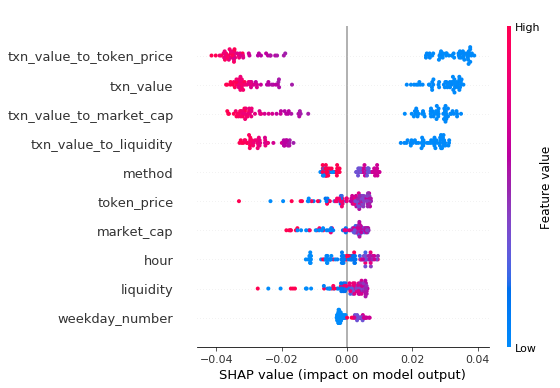

In [13]:
def model_predict(X):
    return model.decision_function(X)
# Using KernelExplainer
explainer = shap.KernelExplainer(model_predict, X)  # X is the background dataset
# Compute SHAP values
shap_values = explainer.shap_values(X)
# Visualize the SHAP values
shap.summary_plot(shap_values, X)

In [10]:
with open('model/large_transaction_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# RAPID TRANSACTION MODEL

In [49]:
input_feature = ['method', 'hour', 'weekday_number', 'txn_time_gap']

In [50]:
model = IsolationForest(n_estimators=300,
                      contamination=0.03,
                      max_features=len(input_feature),
                      verbose=0,
                      random_state=0)

In [51]:
df_rapid_txn = df[(df.txn_time_gap < 100) & (df.txn_time_gap.notnull())]

In [52]:
model.fit(df_rapid_txn[input_feature])

IsolationForest(contamination=0.03, max_features=4, n_estimators=300,
                random_state=0)

In [53]:
df_rapid_txn['rapid_transaction'] = model.predict(df_rapid_txn[input_feature])
df_rapid_txn['rapid_transaction_score'] = model.decision_function(df_rapid_txn[input_feature])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


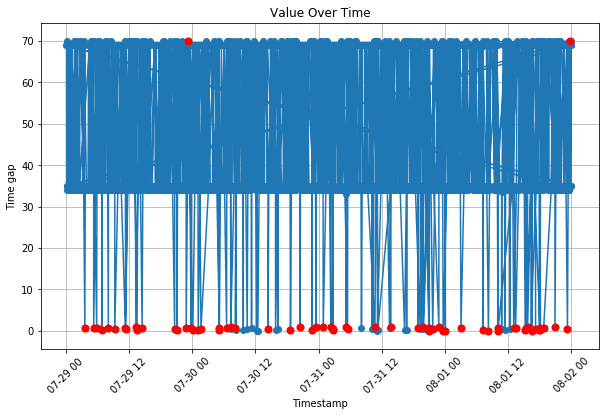

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(df_rapid_txn['time_stamp'], df_rapid_txn['txn_time_gap'], marker='o', linestyle='-')
plt.title('Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Time gap')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.scatter(df_rapid_txn[df_rapid_txn['rapid_transaction'] == -1]['time_stamp'], df_rapid_txn[df_rapid_txn['rapid_transaction'] == -1]['txn_time_gap'], 
            color='red', s=50, label='anomalies', zorder=5)  # Larger size for highlighted points
plt.show()

In [58]:
X = pd.concat([df_rapid_txn[df_rapid_txn.rapid_transaction==1][input_feature].head(50), df_rapid_txn[df_rapid_txn.rapid_transaction==-1][input_feature].head(50)], ignore_index=True)

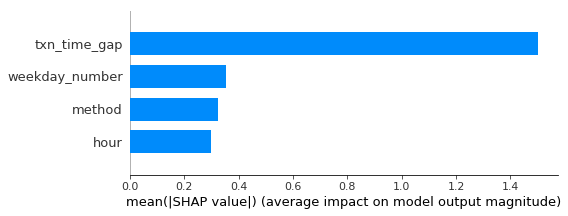

In [59]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

  0%|          | 0/100 [00:00<?, ?it/s]

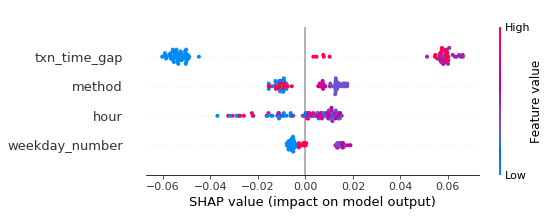

In [60]:
def model_predict(X):
    return model.decision_function(X)
# Using KernelExplainer
explainer = shap.KernelExplainer(model_predict, X)  # X is the background dataset
# Compute SHAP values
shap_values = explainer.shap_values(X)
# Visualize the SHAP values
shap.summary_plot(shap_values, X)

In [61]:
with open('model/rapid_transaction_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# FRAUD TRANSACTION MODEL

In [35]:
input_feature = ['txn_value', 'method', 'token_price', 'liquidity', 'market_cap', 'hour', 'weekday_number',
                 'txn_value_to_token_price', 'txn_value_to_liquidity', 'txn_value_to_market_cap', 'method', 'hour', 'weekday_number', 'txn_time_gap']

In [36]:
model = IsolationForest(n_estimators=300,
#                       contamination=0.01,
                      max_features=len(input_feature),
                      verbose=0,
                      random_state=0)

In [37]:
df = df[df.txn_time_gap.notnull()]

In [38]:
model.fit(df[input_feature])

IsolationForest(max_features=14, n_estimators=300, random_state=0)

In [39]:
df['fraud'] = model.predict(df[input_feature])
df['fraud_score'] = model.decision_function(df[input_feature])

In [40]:
df

,txn_id,time_stamp,txn_maker_address,txn_receiver_address,txn_value,method_called,token_price,liquidity,market_cap,hour,...,weekday_name,txn_time_gap,txn_value_to_token_price,txn_value_to_liquidity,txn_value_to_market_cap,method,large_transaction,large_transaction_score,fraud,fraud_score
1,962bf70bec6ea9bdf5f046d20a7c832f193ad698346cce...,2024-07-29 00:02:52,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,2.71,buy,2.31,1153247.33,3235412.69,0,...,Monday,172.00,117.24,0.00,0.00,1,1,0.10,-1,-0.02
2,58910261cc6a646dbe640094d8813bd77e6b68eb56b569...,2024-07-29 00:05:11,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,3.54,swap,2.29,1153285.00,3235707.52,0,...,Monday,139.00,154.22,0.00,0.00,3,1,0.15,1,0.01
3,e7ac9a71df5e5db5a37eec0ccdb79bea177552173c6c44...,2024-07-29 00:08:03,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,3.91,printMoney,2.30,1153290.16,3236090.14,0,...,Monday,172.00,169.78,0.00,0.00,4,1,0.07,-1,-0.05
4,ce31abfd8bdd378cc1b41b8dfb2b7c326e5d47f7280a15...,2024-07-29 00:09:13,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x00000000fc65059bDdA566b43E17c310B3076e33,3.27,transfer,2.28,1153268.86,3235590.53,0,...,Monday,70.00,143.78,0.00,0.00,2,1,0.14,1,0.00
5,89cbbef418d034d115cdf6ebe6608244f85c61705b8c61...,2024-07-29 00:09:47,0x000000000231c53e9dCbD5Ee410f065FBc170c29,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,3.08,printMoney,2.33,1153284.23,3235355.71,0,...,Monday,34.00,132.15,0.00,0.00,4,1,0.14,-1,-0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639,1eeeed73fb6c67dabc70360ac73f0d7705853d166d841b...,2024-08-01 23:44:26,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.70,buy,2.30,1153299.71,3235789.09,23,...,Thursday,518.00,117.28,0.00,0.00,1,1,0.13,-1,-0.01
8640,ecfd8a3341771976c4d74e3d1284389966f125f5217b68...,2024-08-01 23:52:30,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x639D2a49bdD0CF37614F46a83e4AA49eAFF1e537,2.49,transfer,2.28,1153273.46,3235821.57,23,...,Thursday,484.00,108.85,0.00,0.00,2,1,0.14,-1,-0.00
8641,a5f180b4e56b70851cc85aa80e623b7820654480711d10...,2024-08-01 23:58:16,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x46B3fDF7b5CDe91Ac049936bF0bDb12c5d22202e,2.90,transfer,2.30,1153254.65,3234902.08,23,...,Thursday,346.00,126.27,0.00,0.00,2,1,0.13,1,0.00
8642,34fa716a537c8ede36b56b0ffc02932da8f50d9dc01e24...,2024-08-01 23:59:25,0xdA07eFFA7aEe8CD85feb894e33Da9163f082D19e,0x00000000fc65059bDdA566b43E17c310B3076e33,2.92,transfer,2.32,1153282.39,3235571.15,23,...,Thursday,69.00,125.86,0.00,0.00,2,1,0.17,1,0.03


Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


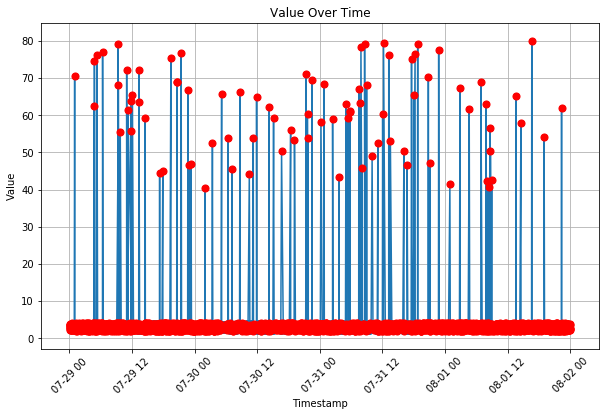

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(df['time_stamp'], df['txn_value'], marker='o', linestyle='-')
plt.title('Value Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.grid(True)
plt.scatter(df[df['fraud'] == -1]['time_stamp'], df[df['fraud'] == -1]['txn_value'], 
            color='red', s=50, label='anomalies', zorder=5)  # Larger size for highlighted points
plt.show()

In [42]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

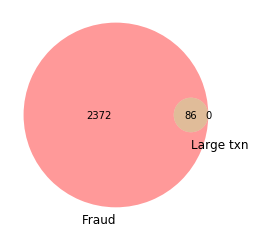

In [46]:
set1 = set(df[df.fraud == -1]['txn_id'].tolist())
set2 = set(df[df.large_transaction == -1]['txn_id'].tolist())
# Calculate overlaps
intersection = set1 & set2
only_in_list1 = set1 - set2
only_in_list2 = set2 - set1
# Create Venn diagram
venn = venn2([set1, set2], set_labels=('Fraud', 'Large txn'))
# Customize colors and text
# Add title and show
plt.show()

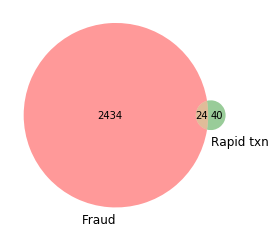

In [55]:
set1 = set(df[df.fraud == -1]['txn_id'].tolist())
set2 = set(df_rapid_txn[df_rapid_txn.rapid_transaction == -1]['txn_id'].tolist())
# Calculate overlaps
intersection = set1 & set2
only_in_list1 = set1 - set2
only_in_list2 = set2 - set1
# Create Venn diagram
venn = venn2([set1, set2], set_labels=('Fraud', 'Rapid txn'))
# Customize colors and text
# Add title and show
plt.show()